In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import xgboost as xgb
from time import time
from sklearn.cross_validation import train_test_split



/Users/elever/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 数据预处理


# 数据处理

In [2]:
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data 

In [3]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [4]:
print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("store.csv")

print("Assume store open, if not provided")
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero. Simplifies calculation of rmspe")
train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
build_features(features, train)
build_features([], test)
print(features)

print('training data processed')

Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero. Simplifies calculation of rmspe
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

rmse_scorer = make_scorer(rmspe, greater_is_better=False)


In [6]:
train = train.sort_values(['Date'],ascending = False)
X_valid = train[:6*7*1115]
X_train = train[6*7*1115:]
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)

In [7]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 600
 
 
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features],y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
 
#模型训练
print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))
 
#采用保留数据集进行检测
print("validating")

yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
 
print('RMSPE: {:.6f}'.format(error))
 



Train a XGBoost model
[0]	train-rmse:5.79275	eval-rmse:5.81859	train-rmspe:0.996833	eval-rmspe:0.99693
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06255	eval-rmse:4.08261	train-rmspe:0.981474	eval-rmspe:0.981933
[2]	train-rmse:2.85358	eval-rmse:2.87136	train-rmspe:0.937935	eval-rmspe:0.939249
[3]	train-rmse:2.0114	eval-rmse:2.0233	train-rmspe:0.856174	eval-rmspe:0.857939
[4]	train-rmse:1.42274	eval-rmse:1.43412	train-rmspe:0.744017	eval-rmspe:0.746361
[5]	train-rmse:1.0176	eval-rmse:1.03465	train-rmspe:0.619675	eval-rmspe:0.623317
[6]	train-rmse:0.738319	eval-rmse:0.752901	train-rmspe:0.504519	eval-rmspe:0.505026
[7]	train-rmse:0.552596	eval-rmse:0.565715	train-rmspe:0.413243	eval-rmspe:0.408318
[8]	train-rmse:0.433171	eval-rmse:0.446712	train-rmspe:0.352499	eval-rmspe:0.34178
[9]	train-rmse:0.360139	eval-rmse:0.374596	train-rmspe:0.315641	eval-rmspe:0.303609
[10]	trai

[96]	train-rmse:0.10112	eval-rmse:0.141076	train-rmspe:0.130595	eval-rmspe:0.145953
[97]	train-rmse:0.100915	eval-rmse:0.140873	train-rmspe:0.130414	eval-rmspe:0.145753
[98]	train-rmse:0.100708	eval-rmse:0.140742	train-rmspe:0.130229	eval-rmspe:0.14564
[99]	train-rmse:0.100391	eval-rmse:0.14081	train-rmspe:0.129847	eval-rmspe:0.145617
[100]	train-rmse:0.100063	eval-rmse:0.140538	train-rmspe:0.1295	eval-rmspe:0.145302
[101]	train-rmse:0.099938	eval-rmse:0.140369	train-rmspe:0.129344	eval-rmspe:0.145372
[102]	train-rmse:0.099647	eval-rmse:0.140252	train-rmspe:0.129079	eval-rmspe:0.145254
[103]	train-rmse:0.099488	eval-rmse:0.140037	train-rmspe:0.127933	eval-rmspe:0.145054
[104]	train-rmse:0.099085	eval-rmse:0.139749	train-rmspe:0.127559	eval-rmspe:0.144744
[105]	train-rmse:0.098966	eval-rmse:0.139658	train-rmspe:0.127438	eval-rmspe:0.144662
[106]	train-rmse:0.098723	eval-rmse:0.139509	train-rmspe:0.127221	eval-rmspe:0.144449
[107]	train-rmse:0.098556	eval-rmse:0.139376	train-rmspe:0.1268

[192]	train-rmse:0.08367	eval-rmse:0.134166	train-rmspe:0.094736	eval-rmspe:0.137978
[193]	train-rmse:0.083557	eval-rmse:0.134135	train-rmspe:0.094629	eval-rmspe:0.137963
[194]	train-rmse:0.08349	eval-rmse:0.134129	train-rmspe:0.094557	eval-rmspe:0.13797
[195]	train-rmse:0.083409	eval-rmse:0.134109	train-rmspe:0.094476	eval-rmspe:0.13795
[196]	train-rmse:0.083303	eval-rmse:0.13404	train-rmspe:0.094357	eval-rmspe:0.137879
[197]	train-rmse:0.083036	eval-rmse:0.133884	train-rmspe:0.094086	eval-rmspe:0.137756
[198]	train-rmse:0.082953	eval-rmse:0.133861	train-rmspe:0.093981	eval-rmspe:0.137725
[199]	train-rmse:0.082927	eval-rmse:0.133857	train-rmspe:0.093954	eval-rmspe:0.137716
[200]	train-rmse:0.082824	eval-rmse:0.133811	train-rmspe:0.093852	eval-rmspe:0.137658
[201]	train-rmse:0.082741	eval-rmse:0.134046	train-rmspe:0.093498	eval-rmspe:0.137744
[202]	train-rmse:0.082556	eval-rmse:0.134051	train-rmspe:0.09324	eval-rmspe:0.137739
[203]	train-rmse:0.082387	eval-rmse:0.134225	train-rmspe:0.0

[288]	train-rmse:0.074441	eval-rmse:0.133161	train-rmspe:0.082579	eval-rmspe:0.137148
[289]	train-rmse:0.074396	eval-rmse:0.133178	train-rmspe:0.082537	eval-rmspe:0.13716
[290]	train-rmse:0.074327	eval-rmse:0.133172	train-rmspe:0.082439	eval-rmspe:0.137148
[291]	train-rmse:0.074282	eval-rmse:0.133155	train-rmspe:0.082393	eval-rmspe:0.137111
[292]	train-rmse:0.074182	eval-rmse:0.133148	train-rmspe:0.08228	eval-rmspe:0.137109
[293]	train-rmse:0.074159	eval-rmse:0.133135	train-rmspe:0.082256	eval-rmspe:0.137103
[294]	train-rmse:0.074065	eval-rmse:0.133133	train-rmspe:0.082151	eval-rmspe:0.137097
[295]	train-rmse:0.073978	eval-rmse:0.133184	train-rmspe:0.082048	eval-rmspe:0.137081
[296]	train-rmse:0.073943	eval-rmse:0.133351	train-rmspe:0.082009	eval-rmspe:0.137296
[297]	train-rmse:0.073871	eval-rmse:0.133326	train-rmspe:0.081918	eval-rmspe:0.137267
[298]	train-rmse:0.073826	eval-rmse:0.133321	train-rmspe:0.08187	eval-rmspe:0.137269
[299]	train-rmse:0.073745	eval-rmse:0.133296	train-rmspe:

weight correction
RMSPE for 0.990:0.151134
RMSPE for 0.991:0.147724
RMSPE for 0.992:0.144668
RMSPE for 0.993:0.142001
RMSPE for 0.994:0.139759
RMSPE for 0.995:0.137975
RMSPE for 0.996:0.136681
RMSPE for 0.997:0.135904
RMSPE for 0.998:0.135669
RMSPE for 0.999:0.135992
RMSPE for 1.000:0.136884
RMSPE for 1.001:0.138350
RMSPE for 1.002:0.140385
RMSPE for 1.003:0.142982
RMSPE for 1.004:0.146124
RMSPE for 1.005:0.149793
RMSPE for 1.006:0.153966
RMSPE for 1.007:0.158618
RMSPE for 1.008:0.163722
RMSPE for 1.009:0.169252
RMSPE for 1.010:0.175182
Best weight for Score:0.998    0.135669
dtype: float64


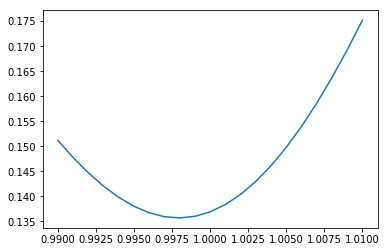

In [27]:

print("weight correction")
W=np.arange(0.99,1.01,0.001)
S =[]
for w in W:
    error = rmspe(np.expm1(y_valid), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [28]:
weights  = np.arange(0.99,1.01,0.001)

error  = {w :0 for w in weights}


In [29]:
X_valid['Prediction'] = yhat
#X_valid.sort_index(by = 'Store',inplace = True)

#X_test = test[features].sort_index(by='Store')
X_valid['Weights'] = 0
X_test = test[features]
X_test['Weights'] = 0


/Users/elever/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/elever/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/elever/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [30]:
for i in range(1,1116):
   # s1 = X_valid.loc[X_valid['Store'] == i]
    #s2 = X_valid.loc[X_valid['Store' ]== i]
    for w in weights:
        error[w] = rmspe(X_valid.loc[X_valid['Store'] == i].Sales,np.expm1(X_valid.loc[X_valid['Store'] == i].Prediction*w))
    w_best = min(error, key = error.get)
    X_valid.loc[X_valid['Store'] == i,'Weights'] = w_best
    X_test.loc[X_test['Store'] == i,'Weights']= w_best
X_test

/Users/elever/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Store,CompetitionDistance,Promo,Promo2,SchoolHoliday,StoreType,Assortment,StateHoliday,DayOfWeek,Month,Day,Year,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Weights
0,1,1270.0,1,0,0.0,3,1,0,3,9,17,2015,38,84.0,0.00,0,0.996
1,1,1270.0,1,0,0.0,3,1,0,2,9,16,2015,38,84.0,0.00,0,0.996
2,1,1270.0,1,0,0.0,3,1,0,1,9,15,2015,38,84.0,0.00,0,0.996
3,1,1270.0,1,0,0.0,3,1,0,0,9,14,2015,38,84.0,0.00,0,0.996
4,1,1270.0,0,0,0.0,3,1,0,6,9,13,2015,37,84.0,0.00,0,0.996
5,1,1270.0,0,0,0.0,3,1,0,5,9,12,2015,37,84.0,0.00,0,0.996
6,1,1270.0,0,0,0.0,3,1,0,4,9,11,2015,37,84.0,0.00,0,0.996
7,1,1270.0,0,0,0.0,3,1,0,3,9,10,2015,37,84.0,0.00,0,0.996
8,1,1270.0,0,0,0.0,3,1,0,2,9,9,2015,37,84.0,0.00,0,0.996
9,1,1270.0,0,0,0.0,3,1,0,1,9,8,2015,37,84.0,0.00,0,0.996


In [31]:
dtest = xgb.DMatrix(test[features])
test_probs =  gbm.predict(dtest)
error1=  rmspe(X_valid.Sales,np.expm1(yhat))
print ('RMSPE  {:6f}'.format(error1))
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv('Xgboost_wu_submission_13.csv',index = False)

error_en = rmspe(X_valid.Sales,np.expm1(X_valid.Prediction*X_valid.Weights))
print ('RMSPE for weight corretion {:6f}'.format(error_en))
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs*X_test.Weights)})
result.to_csv("Xgboost_wu_submission_14.csv", index=False)

RMSPE  0.136884
RMSPE for weight corretion 0.123684


In [32]:
weights  = np.arange(0.98,1.02,0.001)
error  = {w :0 for w in weights}

In [33]:
%%time
#error_round = []
#error_round_corr = []

y_pre_matrix = np.zeros((len(y_valid.index),10))
y_test_matrix = np.zeros((len(X_test.index),10))
for r in range(10):
    print('round {}:\n'.format(r))
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": r+10
          }
    num_boost_round = 600
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                    early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
    
    yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
    
    X_valid['Prediction'] = yhat
    for i in range(1,1116):
        for w in weights:
            error[w] = rmspe(X_valid.loc[X_valid['Store'] == i].Sales,np.expm1(X_valid.loc[X_valid['Store'] == i].Prediction*w))
    
    w_best = min(error, key = error.get)
    X_valid.loc[X_valid['Store'] == i,'Weights'] = w_best
    X_test.loc[X_test['Store'] == i,'Weights']= w_best
    
    #error_tmp = rmspe(X_valid.Sales,np.expm1(yhat))
    #error_tmp1 = rmspe(X_valid.Sales,np.expm1(yhat*X_valid.Weights))
    #print("RMSPE: {:0.4f},RMSPE after correction :{0.4f}".format(error_tmp,error_tmp1))
    #error_round.append(error_tmp)
    #error_round_corr.append(error_tmp1)

    
    yhat_test = gbm.predict(dtest) *X_test.Weights
    y_pre_matrix[:,r] = (X_valid.Prediction * X_valid.Weights).tolist()
    
    y_test_matrix[:,r] = yhat_test.tolist()
    

round 0:

[0]	train-rmse:5.79275	eval-rmse:5.81859	train-rmspe:0.996833	eval-rmspe:0.99693
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06255	eval-rmse:4.08261	train-rmspe:0.981474	eval-rmspe:0.981933
[2]	train-rmse:2.85358	eval-rmse:2.87136	train-rmspe:0.937935	eval-rmspe:0.939249
[3]	train-rmse:2.0114	eval-rmse:2.0233	train-rmspe:0.856174	eval-rmspe:0.857939
[4]	train-rmse:1.42274	eval-rmse:1.43412	train-rmspe:0.744017	eval-rmspe:0.746361
[5]	train-rmse:1.0176	eval-rmse:1.03465	train-rmspe:0.619675	eval-rmspe:0.623317
[6]	train-rmse:0.738319	eval-rmse:0.752901	train-rmspe:0.504519	eval-rmspe:0.505026
[7]	train-rmse:0.552596	eval-rmse:0.565715	train-rmspe:0.413243	eval-rmspe:0.408318
[8]	train-rmse:0.433171	eval-rmse:0.446712	train-rmspe:0.352499	eval-rmspe:0.34178
[9]	train-rmse:0.360139	eval-rmse:0.374596	train-rmspe:0.315641	eval-rmspe:0.303609
[10]	train-rmse:0.317

[96]	train-rmse:0.10112	eval-rmse:0.141076	train-rmspe:0.130595	eval-rmspe:0.145953
[97]	train-rmse:0.100915	eval-rmse:0.140873	train-rmspe:0.130414	eval-rmspe:0.145753
[98]	train-rmse:0.100708	eval-rmse:0.140742	train-rmspe:0.130229	eval-rmspe:0.14564
[99]	train-rmse:0.100391	eval-rmse:0.14081	train-rmspe:0.129847	eval-rmspe:0.145617
[100]	train-rmse:0.100063	eval-rmse:0.140538	train-rmspe:0.1295	eval-rmspe:0.145302
[101]	train-rmse:0.099938	eval-rmse:0.140369	train-rmspe:0.129344	eval-rmspe:0.145372
[102]	train-rmse:0.099647	eval-rmse:0.140252	train-rmspe:0.129079	eval-rmspe:0.145254
[103]	train-rmse:0.099488	eval-rmse:0.140037	train-rmspe:0.127933	eval-rmspe:0.145054
[104]	train-rmse:0.099085	eval-rmse:0.139749	train-rmspe:0.127559	eval-rmspe:0.144744
[105]	train-rmse:0.098966	eval-rmse:0.139658	train-rmspe:0.127438	eval-rmspe:0.144662
[106]	train-rmse:0.098723	eval-rmse:0.139509	train-rmspe:0.127221	eval-rmspe:0.144449
[107]	train-rmse:0.098556	eval-rmse:0.139376	train-rmspe:0.1268

[192]	train-rmse:0.08367	eval-rmse:0.134166	train-rmspe:0.094736	eval-rmspe:0.137978
[193]	train-rmse:0.083557	eval-rmse:0.134135	train-rmspe:0.094629	eval-rmspe:0.137963
[194]	train-rmse:0.08349	eval-rmse:0.134129	train-rmspe:0.094557	eval-rmspe:0.13797
[195]	train-rmse:0.083409	eval-rmse:0.134109	train-rmspe:0.094476	eval-rmspe:0.13795
[196]	train-rmse:0.083303	eval-rmse:0.13404	train-rmspe:0.094357	eval-rmspe:0.137879
[197]	train-rmse:0.083036	eval-rmse:0.133884	train-rmspe:0.094086	eval-rmspe:0.137756
[198]	train-rmse:0.082953	eval-rmse:0.133861	train-rmspe:0.093981	eval-rmspe:0.137725
[199]	train-rmse:0.082927	eval-rmse:0.133857	train-rmspe:0.093954	eval-rmspe:0.137716
[200]	train-rmse:0.082824	eval-rmse:0.133811	train-rmspe:0.093852	eval-rmspe:0.137658
[201]	train-rmse:0.082741	eval-rmse:0.134046	train-rmspe:0.093498	eval-rmspe:0.137744
[202]	train-rmse:0.082556	eval-rmse:0.134051	train-rmspe:0.09324	eval-rmspe:0.137739
[203]	train-rmse:0.082387	eval-rmse:0.134225	train-rmspe:0.0

[288]	train-rmse:0.074441	eval-rmse:0.133161	train-rmspe:0.082579	eval-rmspe:0.137148
[289]	train-rmse:0.074396	eval-rmse:0.133178	train-rmspe:0.082537	eval-rmspe:0.13716
[290]	train-rmse:0.074327	eval-rmse:0.133172	train-rmspe:0.082439	eval-rmspe:0.137148
[291]	train-rmse:0.074282	eval-rmse:0.133155	train-rmspe:0.082393	eval-rmspe:0.137111
[292]	train-rmse:0.074182	eval-rmse:0.133148	train-rmspe:0.08228	eval-rmspe:0.137109
[293]	train-rmse:0.074159	eval-rmse:0.133135	train-rmspe:0.082256	eval-rmspe:0.137103
[294]	train-rmse:0.074065	eval-rmse:0.133133	train-rmspe:0.082151	eval-rmspe:0.137097
[295]	train-rmse:0.073978	eval-rmse:0.133184	train-rmspe:0.082048	eval-rmspe:0.137081
[296]	train-rmse:0.073943	eval-rmse:0.133351	train-rmspe:0.082009	eval-rmspe:0.137296
[297]	train-rmse:0.073871	eval-rmse:0.133326	train-rmspe:0.081918	eval-rmspe:0.137267
[298]	train-rmse:0.073826	eval-rmse:0.133321	train-rmspe:0.08187	eval-rmspe:0.137269
[299]	train-rmse:0.073745	eval-rmse:0.133296	train-rmspe:

/Users/elever/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/elever/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


round 1:

[0]	train-rmse:5.79267	eval-rmse:5.81989	train-rmspe:0.996831	eval-rmspe:0.996931
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.062	eval-rmse:4.08658	train-rmspe:0.981513	eval-rmspe:0.982041
[2]	train-rmse:2.85242	eval-rmse:2.87833	train-rmspe:0.938117	eval-rmspe:0.939914
[3]	train-rmse:2.00899	eval-rmse:2.0281	train-rmspe:0.856752	eval-rmspe:0.859555
[4]	train-rmse:1.42128	eval-rmse:1.43705	train-rmspe:0.744457	eval-rmspe:0.748024
[5]	train-rmse:1.0164	eval-rmse:1.03026	train-rmspe:0.619935	eval-rmspe:0.622617
[6]	train-rmse:0.73779	eval-rmse:0.750429	train-rmspe:0.504989	eval-rmspe:0.504577
[7]	train-rmse:0.548134	eval-rmse:0.559654	train-rmspe:0.411338	eval-rmspe:0.406092
[8]	train-rmse:0.42349	eval-rmse:0.435759	train-rmspe:0.345881	eval-rmspe:0.334809
[9]	train-rmse:0.340458	eval-rmse:0.349654	train-rmspe:0.304421	eval-rmspe:0.284305
[10]	train-rmse:0.2935

[96]	train-rmse:0.100801	eval-rmse:0.136097	train-rmspe:0.123038	eval-rmspe:0.140963
[97]	train-rmse:0.100539	eval-rmse:0.13603	train-rmspe:0.122128	eval-rmspe:0.140896
[98]	train-rmse:0.100068	eval-rmse:0.135678	train-rmspe:0.121693	eval-rmspe:0.140503
[99]	train-rmse:0.099709	eval-rmse:0.135561	train-rmspe:0.12133	eval-rmspe:0.140406
[100]	train-rmse:0.099497	eval-rmse:0.135423	train-rmspe:0.121002	eval-rmspe:0.140258
[101]	train-rmse:0.099415	eval-rmse:0.135396	train-rmspe:0.12092	eval-rmspe:0.140226
[102]	train-rmse:0.099087	eval-rmse:0.13528	train-rmspe:0.120401	eval-rmspe:0.140172
[103]	train-rmse:0.098971	eval-rmse:0.135213	train-rmspe:0.120289	eval-rmspe:0.140109
[104]	train-rmse:0.098728	eval-rmse:0.135131	train-rmspe:0.12006	eval-rmspe:0.140025
[105]	train-rmse:0.098458	eval-rmse:0.134908	train-rmspe:0.119818	eval-rmspe:0.139721
[106]	train-rmse:0.098222	eval-rmse:0.134733	train-rmspe:0.119524	eval-rmspe:0.139546
[107]	train-rmse:0.098145	eval-rmse:0.134706	train-rmspe:0.1194

[192]	train-rmse:0.083336	eval-rmse:0.128757	train-rmspe:0.09395	eval-rmspe:0.133493
[193]	train-rmse:0.083241	eval-rmse:0.128723	train-rmspe:0.093785	eval-rmspe:0.133454
[194]	train-rmse:0.083122	eval-rmse:0.128612	train-rmspe:0.093634	eval-rmspe:0.13333
[195]	train-rmse:0.082998	eval-rmse:0.128595	train-rmspe:0.093485	eval-rmspe:0.133339
[196]	train-rmse:0.082933	eval-rmse:0.128505	train-rmspe:0.093401	eval-rmspe:0.132884
[197]	train-rmse:0.082804	eval-rmse:0.128486	train-rmspe:0.093259	eval-rmspe:0.132905
[198]	train-rmse:0.082683	eval-rmse:0.128392	train-rmspe:0.093127	eval-rmspe:0.132822
[199]	train-rmse:0.082566	eval-rmse:0.128388	train-rmspe:0.092996	eval-rmspe:0.132825
[200]	train-rmse:0.082483	eval-rmse:0.128354	train-rmspe:0.092916	eval-rmspe:0.132792
[201]	train-rmse:0.082346	eval-rmse:0.128312	train-rmspe:0.09278	eval-rmspe:0.132758
[202]	train-rmse:0.082275	eval-rmse:0.128323	train-rmspe:0.092705	eval-rmspe:0.132772
[203]	train-rmse:0.082187	eval-rmse:0.128293	train-rmspe:

[288]	train-rmse:0.074924	eval-rmse:0.128392	train-rmspe:0.081874	eval-rmspe:0.132039
[289]	train-rmse:0.07485	eval-rmse:0.128384	train-rmspe:0.081758	eval-rmspe:0.132042
[290]	train-rmse:0.07476	eval-rmse:0.128332	train-rmspe:0.081657	eval-rmspe:0.132008
[291]	train-rmse:0.074685	eval-rmse:0.128401	train-rmspe:0.081576	eval-rmspe:0.132065
[292]	train-rmse:0.074575	eval-rmse:0.128338	train-rmspe:0.081086	eval-rmspe:0.132016
[293]	train-rmse:0.074543	eval-rmse:0.128299	train-rmspe:0.081058	eval-rmspe:0.131968
[294]	train-rmse:0.07445	eval-rmse:0.128294	train-rmspe:0.080936	eval-rmspe:0.131967
[295]	train-rmse:0.07439	eval-rmse:0.128305	train-rmspe:0.080875	eval-rmspe:0.132
[296]	train-rmse:0.074318	eval-rmse:0.128306	train-rmspe:0.0808	eval-rmspe:0.131996
[297]	train-rmse:0.074269	eval-rmse:0.128299	train-rmspe:0.080749	eval-rmspe:0.131992
[298]	train-rmse:0.074201	eval-rmse:0.128267	train-rmspe:0.080683	eval-rmspe:0.131953
[299]	train-rmse:0.074133	eval-rmse:0.128245	train-rmspe:0.0805

[50]	train-rmse:0.126499	eval-rmse:0.156364	train-rmspe:0.170288	eval-rmspe:0.167661
[51]	train-rmse:0.125087	eval-rmse:0.155078	train-rmspe:0.168822	eval-rmspe:0.166162
[52]	train-rmse:0.124404	eval-rmse:0.155475	train-rmspe:0.168326	eval-rmspe:0.166789
[53]	train-rmse:0.123212	eval-rmse:0.154574	train-rmspe:0.167263	eval-rmspe:0.165771
[54]	train-rmse:0.122775	eval-rmse:0.154627	train-rmspe:0.166846	eval-rmspe:0.166106
[55]	train-rmse:0.121485	eval-rmse:0.153701	train-rmspe:0.165721	eval-rmspe:0.165064
[56]	train-rmse:0.119643	eval-rmse:0.152118	train-rmspe:0.164179	eval-rmspe:0.163194
[57]	train-rmse:0.118755	eval-rmse:0.151722	train-rmspe:0.163418	eval-rmspe:0.162758
[58]	train-rmse:0.11792	eval-rmse:0.151074	train-rmspe:0.162665	eval-rmspe:0.162008
[59]	train-rmse:0.117171	eval-rmse:0.150398	train-rmspe:0.161751	eval-rmspe:0.161273
[60]	train-rmse:0.11534	eval-rmse:0.148862	train-rmspe:0.160021	eval-rmspe:0.159547
[61]	train-rmse:0.114638	eval-rmse:0.148795	train-rmspe:0.159393	ev

[147]	train-rmse:0.088367	eval-rmse:0.135003	train-rmspe:0.109123	eval-rmspe:0.144245
[148]	train-rmse:0.088064	eval-rmse:0.134856	train-rmspe:0.108788	eval-rmspe:0.143997
[149]	train-rmse:0.087936	eval-rmse:0.134816	train-rmspe:0.108668	eval-rmspe:0.143995
[150]	train-rmse:0.087726	eval-rmse:0.134811	train-rmspe:0.10733	eval-rmspe:0.143979
[151]	train-rmse:0.087567	eval-rmse:0.135007	train-rmspe:0.10711	eval-rmspe:0.144385
[152]	train-rmse:0.087495	eval-rmse:0.134991	train-rmspe:0.107047	eval-rmspe:0.14438
[153]	train-rmse:0.087363	eval-rmse:0.134957	train-rmspe:0.106255	eval-rmspe:0.144356
[154]	train-rmse:0.08724	eval-rmse:0.134878	train-rmspe:0.106124	eval-rmspe:0.144278
[155]	train-rmse:0.087115	eval-rmse:0.134801	train-rmspe:0.106011	eval-rmspe:0.144185
[156]	train-rmse:0.087059	eval-rmse:0.134793	train-rmspe:0.105954	eval-rmspe:0.144165
[157]	train-rmse:0.086961	eval-rmse:0.134803	train-rmspe:0.105861	eval-rmspe:0.144201
[158]	train-rmse:0.08682	eval-rmse:0.134644	train-rmspe:0.

[243]	train-rmse:0.077408	eval-rmse:0.132629	train-rmspe:0.084871	eval-rmspe:0.141715
[244]	train-rmse:0.077327	eval-rmse:0.132642	train-rmspe:0.084788	eval-rmspe:0.141738
[245]	train-rmse:0.077243	eval-rmse:0.13261	train-rmspe:0.084701	eval-rmspe:0.141725
[246]	train-rmse:0.077178	eval-rmse:0.132573	train-rmspe:0.084596	eval-rmspe:0.141677
[247]	train-rmse:0.077095	eval-rmse:0.132584	train-rmspe:0.083773	eval-rmspe:0.141703
[248]	train-rmse:0.076997	eval-rmse:0.13252	train-rmspe:0.083677	eval-rmspe:0.141622
[249]	train-rmse:0.076913	eval-rmse:0.132499	train-rmspe:0.083554	eval-rmspe:0.141592
[250]	train-rmse:0.076863	eval-rmse:0.132531	train-rmspe:0.083586	eval-rmspe:0.141612
[251]	train-rmse:0.076793	eval-rmse:0.132536	train-rmspe:0.083437	eval-rmspe:0.141637
[252]	train-rmse:0.07674	eval-rmse:0.132537	train-rmspe:0.083388	eval-rmspe:0.141635
[253]	train-rmse:0.076643	eval-rmse:0.132526	train-rmspe:0.083257	eval-rmspe:0.141593
[254]	train-rmse:0.076548	eval-rmse:0.13256	train-rmspe:0

[339]	train-rmse:0.070928	eval-rmse:0.132057	train-rmspe:0.076042	eval-rmspe:0.141039
[340]	train-rmse:0.070867	eval-rmse:0.132052	train-rmspe:0.075971	eval-rmspe:0.141036
[341]	train-rmse:0.070778	eval-rmse:0.132033	train-rmspe:0.075871	eval-rmspe:0.141002
[342]	train-rmse:0.070682	eval-rmse:0.132001	train-rmspe:0.075754	eval-rmspe:0.14096
[343]	train-rmse:0.070612	eval-rmse:0.131985	train-rmspe:0.075682	eval-rmspe:0.14093
[344]	train-rmse:0.070545	eval-rmse:0.131981	train-rmspe:0.075529	eval-rmspe:0.140924
[345]	train-rmse:0.070456	eval-rmse:0.131983	train-rmspe:0.075387	eval-rmspe:0.140947
[346]	train-rmse:0.070371	eval-rmse:0.131973	train-rmspe:0.075292	eval-rmspe:0.14094
[347]	train-rmse:0.070295	eval-rmse:0.131952	train-rmspe:0.0752	eval-rmspe:0.140914
[348]	train-rmse:0.070239	eval-rmse:0.13195	train-rmspe:0.075125	eval-rmspe:0.14091
[349]	train-rmse:0.070156	eval-rmse:0.131977	train-rmspe:0.07501	eval-rmspe:0.140939
[350]	train-rmse:0.07011	eval-rmse:0.131983	train-rmspe:0.0746

[435]	train-rmse:0.065931	eval-rmse:0.132291	train-rmspe:0.069161	eval-rmspe:0.141159
[436]	train-rmse:0.065907	eval-rmse:0.132335	train-rmspe:0.069137	eval-rmspe:0.14121
[437]	train-rmse:0.06585	eval-rmse:0.132321	train-rmspe:0.069075	eval-rmspe:0.141194
[438]	train-rmse:0.065811	eval-rmse:0.132328	train-rmspe:0.06903	eval-rmspe:0.141184
[439]	train-rmse:0.06576	eval-rmse:0.132303	train-rmspe:0.068966	eval-rmspe:0.141167
[440]	train-rmse:0.065733	eval-rmse:0.1323	train-rmspe:0.068939	eval-rmspe:0.141163
[441]	train-rmse:0.065691	eval-rmse:0.132276	train-rmspe:0.068887	eval-rmspe:0.141133
[442]	train-rmse:0.065637	eval-rmse:0.132288	train-rmspe:0.068821	eval-rmspe:0.141149
[443]	train-rmse:0.065589	eval-rmse:0.13229	train-rmspe:0.068764	eval-rmspe:0.141151
[444]	train-rmse:0.065548	eval-rmse:0.132321	train-rmspe:0.068709	eval-rmspe:0.141177
[445]	train-rmse:0.065497	eval-rmse:0.132318	train-rmspe:0.068653	eval-rmspe:0.141174
[446]	train-rmse:0.06546	eval-rmse:0.132324	train-rmspe:0.068

[70]	train-rmse:0.111848	eval-rmse:0.146994	train-rmspe:0.128967	eval-rmspe:0.15854
[71]	train-rmse:0.111309	eval-rmse:0.14686	train-rmspe:0.127682	eval-rmspe:0.158383
[72]	train-rmse:0.111023	eval-rmse:0.146867	train-rmspe:0.127303	eval-rmspe:0.158325
[73]	train-rmse:0.110482	eval-rmse:0.146383	train-rmspe:0.126742	eval-rmspe:0.157784
[74]	train-rmse:0.110152	eval-rmse:0.14576	train-rmspe:0.12635	eval-rmspe:0.156799
[75]	train-rmse:0.109836	eval-rmse:0.145473	train-rmspe:0.126053	eval-rmspe:0.156511
[76]	train-rmse:0.109197	eval-rmse:0.144699	train-rmspe:0.12544	eval-rmspe:0.155634
[77]	train-rmse:0.108647	eval-rmse:0.144198	train-rmspe:0.124833	eval-rmspe:0.155183
[78]	train-rmse:0.108409	eval-rmse:0.144	train-rmspe:0.124596	eval-rmspe:0.154969
[79]	train-rmse:0.108119	eval-rmse:0.143919	train-rmspe:0.124328	eval-rmspe:0.15491
[80]	train-rmse:0.107632	eval-rmse:0.143489	train-rmspe:0.123795	eval-rmspe:0.15445
[81]	train-rmse:0.107413	eval-rmse:0.143309	train-rmspe:0.123588	eval-rmspe

[167]	train-rmse:0.086632	eval-rmse:0.132592	train-rmspe:0.095473	eval-rmspe:0.142112
[168]	train-rmse:0.086529	eval-rmse:0.132551	train-rmspe:0.095357	eval-rmspe:0.142069
[169]	train-rmse:0.086419	eval-rmse:0.132491	train-rmspe:0.095207	eval-rmspe:0.141987
[170]	train-rmse:0.086223	eval-rmse:0.132413	train-rmspe:0.094974	eval-rmspe:0.141907
[171]	train-rmse:0.085967	eval-rmse:0.132291	train-rmspe:0.094658	eval-rmspe:0.14179
[172]	train-rmse:0.085715	eval-rmse:0.132214	train-rmspe:0.094404	eval-rmspe:0.141692
[173]	train-rmse:0.085428	eval-rmse:0.13207	train-rmspe:0.094108	eval-rmspe:0.141537
[174]	train-rmse:0.085308	eval-rmse:0.132067	train-rmspe:0.093943	eval-rmspe:0.141529
[175]	train-rmse:0.085159	eval-rmse:0.132023	train-rmspe:0.093756	eval-rmspe:0.141467
[176]	train-rmse:0.08508	eval-rmse:0.131972	train-rmspe:0.093661	eval-rmspe:0.141405
[177]	train-rmse:0.084956	eval-rmse:0.131927	train-rmspe:0.093545	eval-rmspe:0.141361
[178]	train-rmse:0.08469	eval-rmse:0.131781	train-rmspe:0

[263]	train-rmse:0.076332	eval-rmse:0.12952	train-rmspe:0.082973	eval-rmspe:0.138945
[264]	train-rmse:0.076218	eval-rmse:0.129466	train-rmspe:0.082817	eval-rmspe:0.138897
[265]	train-rmse:0.076178	eval-rmse:0.129444	train-rmspe:0.082774	eval-rmspe:0.138861
[266]	train-rmse:0.076088	eval-rmse:0.129389	train-rmspe:0.082658	eval-rmspe:0.138805
[267]	train-rmse:0.075954	eval-rmse:0.129373	train-rmspe:0.082485	eval-rmspe:0.138789
[268]	train-rmse:0.075888	eval-rmse:0.12936	train-rmspe:0.082372	eval-rmspe:0.138751
[269]	train-rmse:0.075843	eval-rmse:0.129351	train-rmspe:0.082309	eval-rmspe:0.138738
[270]	train-rmse:0.075731	eval-rmse:0.129294	train-rmspe:0.082196	eval-rmspe:0.138673
[271]	train-rmse:0.075661	eval-rmse:0.129273	train-rmspe:0.08209	eval-rmspe:0.138628
[272]	train-rmse:0.075615	eval-rmse:0.129276	train-rmspe:0.082025	eval-rmspe:0.138649
[273]	train-rmse:0.075561	eval-rmse:0.129266	train-rmspe:0.081966	eval-rmspe:0.138642
[274]	train-rmse:0.07549	eval-rmse:0.129244	train-rmspe:0

[359]	train-rmse:0.069824	eval-rmse:0.128264	train-rmspe:0.074309	eval-rmspe:0.137585
[360]	train-rmse:0.069761	eval-rmse:0.128272	train-rmspe:0.074242	eval-rmspe:0.137591
[361]	train-rmse:0.069702	eval-rmse:0.128251	train-rmspe:0.07416	eval-rmspe:0.13757
[362]	train-rmse:0.06966	eval-rmse:0.128249	train-rmspe:0.074118	eval-rmspe:0.137575
[363]	train-rmse:0.069581	eval-rmse:0.128235	train-rmspe:0.074028	eval-rmspe:0.137573
[364]	train-rmse:0.069517	eval-rmse:0.128201	train-rmspe:0.073958	eval-rmspe:0.137541
[365]	train-rmse:0.069451	eval-rmse:0.128183	train-rmspe:0.073869	eval-rmspe:0.137509
[366]	train-rmse:0.069401	eval-rmse:0.128182	train-rmspe:0.073808	eval-rmspe:0.137511
[367]	train-rmse:0.069335	eval-rmse:0.128166	train-rmspe:0.073719	eval-rmspe:0.137502
[368]	train-rmse:0.069282	eval-rmse:0.12819	train-rmspe:0.073654	eval-rmspe:0.137535
[369]	train-rmse:0.069234	eval-rmse:0.128176	train-rmspe:0.073598	eval-rmspe:0.137513
[370]	train-rmse:0.069166	eval-rmse:0.128172	train-rmspe:0

[455]	train-rmse:0.065086	eval-rmse:0.127882	train-rmspe:0.068364	eval-rmspe:0.137153
[456]	train-rmse:0.065034	eval-rmse:0.127874	train-rmspe:0.068297	eval-rmspe:0.137144
[457]	train-rmse:0.065018	eval-rmse:0.127882	train-rmspe:0.06828	eval-rmspe:0.137158
[458]	train-rmse:0.06499	eval-rmse:0.12788	train-rmspe:0.068252	eval-rmspe:0.137163
[459]	train-rmse:0.064948	eval-rmse:0.127856	train-rmspe:0.068212	eval-rmspe:0.137127
[460]	train-rmse:0.064908	eval-rmse:0.127883	train-rmspe:0.068171	eval-rmspe:0.137149
[461]	train-rmse:0.064876	eval-rmse:0.127877	train-rmspe:0.068138	eval-rmspe:0.137138
[462]	train-rmse:0.06484	eval-rmse:0.127895	train-rmspe:0.068095	eval-rmspe:0.13716
[463]	train-rmse:0.064794	eval-rmse:0.127871	train-rmspe:0.068046	eval-rmspe:0.137128
[464]	train-rmse:0.064736	eval-rmse:0.127867	train-rmspe:0.06796	eval-rmspe:0.137123
[465]	train-rmse:0.064686	eval-rmse:0.127867	train-rmspe:0.067916	eval-rmspe:0.137134
[466]	train-rmse:0.064661	eval-rmse:0.127897	train-rmspe:0.0

[551]	train-rmse:0.061153	eval-rmse:0.128024	train-rmspe:0.063783	eval-rmspe:0.137424
[552]	train-rmse:0.061124	eval-rmse:0.128029	train-rmspe:0.063755	eval-rmspe:0.137429
[553]	train-rmse:0.061074	eval-rmse:0.128041	train-rmspe:0.063693	eval-rmspe:0.137435
[554]	train-rmse:0.061041	eval-rmse:0.128043	train-rmspe:0.063654	eval-rmspe:0.137433
[555]	train-rmse:0.061003	eval-rmse:0.128064	train-rmspe:0.063617	eval-rmspe:0.137467
[556]	train-rmse:0.060935	eval-rmse:0.128047	train-rmspe:0.063523	eval-rmspe:0.137423
[557]	train-rmse:0.060904	eval-rmse:0.128051	train-rmspe:0.063485	eval-rmspe:0.137428
[558]	train-rmse:0.060856	eval-rmse:0.128051	train-rmspe:0.063427	eval-rmspe:0.13742
[559]	train-rmse:0.060825	eval-rmse:0.128052	train-rmspe:0.063398	eval-rmspe:0.137426
[560]	train-rmse:0.060796	eval-rmse:0.128071	train-rmspe:0.063366	eval-rmspe:0.137451
[561]	train-rmse:0.060745	eval-rmse:0.128074	train-rmspe:0.063289	eval-rmspe:0.137464
[562]	train-rmse:0.060711	eval-rmse:0.12807	train-rmspe

[80]	train-rmse:0.106869	eval-rmse:0.145345	train-rmspe:0.123439	eval-rmspe:0.152863
[81]	train-rmse:0.10651	eval-rmse:0.145061	train-rmspe:0.122917	eval-rmspe:0.152565
[82]	train-rmse:0.106093	eval-rmse:0.144819	train-rmspe:0.122531	eval-rmspe:0.152324
[83]	train-rmse:0.105812	eval-rmse:0.144708	train-rmspe:0.12209	eval-rmspe:0.152191
[84]	train-rmse:0.105357	eval-rmse:0.145673	train-rmspe:0.121547	eval-rmspe:0.153576
[85]	train-rmse:0.105156	eval-rmse:0.145551	train-rmspe:0.121332	eval-rmspe:0.153491
[86]	train-rmse:0.10506	eval-rmse:0.145485	train-rmspe:0.121217	eval-rmspe:0.153428
[87]	train-rmse:0.104414	eval-rmse:0.14492	train-rmspe:0.120553	eval-rmspe:0.15284
[88]	train-rmse:0.104289	eval-rmse:0.144905	train-rmspe:0.12043	eval-rmspe:0.152817
[89]	train-rmse:0.10406	eval-rmse:0.144776	train-rmspe:0.120188	eval-rmspe:0.15266
[90]	train-rmse:0.103598	eval-rmse:0.144482	train-rmspe:0.119762	eval-rmspe:0.152356
[91]	train-rmse:0.103256	eval-rmse:0.144368	train-rmspe:0.119366	eval-rms

[177]	train-rmse:0.085037	eval-rmse:0.13583	train-rmspe:0.096367	eval-rmspe:0.142802
[178]	train-rmse:0.084935	eval-rmse:0.13575	train-rmspe:0.096251	eval-rmspe:0.1427
[179]	train-rmse:0.084807	eval-rmse:0.135704	train-rmspe:0.096111	eval-rmspe:0.142681
[180]	train-rmse:0.084693	eval-rmse:0.135691	train-rmspe:0.095688	eval-rmspe:0.142681
[181]	train-rmse:0.084594	eval-rmse:0.135663	train-rmspe:0.095582	eval-rmspe:0.142629
[182]	train-rmse:0.084521	eval-rmse:0.13566	train-rmspe:0.095512	eval-rmspe:0.142638
[183]	train-rmse:0.084311	eval-rmse:0.135548	train-rmspe:0.095197	eval-rmspe:0.142544
[184]	train-rmse:0.084141	eval-rmse:0.136015	train-rmspe:0.094965	eval-rmspe:0.142846
[185]	train-rmse:0.083996	eval-rmse:0.135954	train-rmspe:0.094803	eval-rmspe:0.142771
[186]	train-rmse:0.083826	eval-rmse:0.135875	train-rmspe:0.094609	eval-rmspe:0.142678
[187]	train-rmse:0.083714	eval-rmse:0.135837	train-rmspe:0.094472	eval-rmspe:0.14261
[188]	train-rmse:0.083526	eval-rmse:0.135758	train-rmspe:0.0

[273]	train-rmse:0.075653	eval-rmse:0.134467	train-rmspe:0.083247	eval-rmspe:0.141267
[274]	train-rmse:0.075586	eval-rmse:0.134447	train-rmspe:0.08316	eval-rmspe:0.141249
[275]	train-rmse:0.075529	eval-rmse:0.134447	train-rmspe:0.083096	eval-rmspe:0.141268
[276]	train-rmse:0.075476	eval-rmse:0.134441	train-rmspe:0.083042	eval-rmspe:0.141264
[277]	train-rmse:0.07539	eval-rmse:0.134496	train-rmspe:0.08295	eval-rmspe:0.141348
[278]	train-rmse:0.075316	eval-rmse:0.134484	train-rmspe:0.082851	eval-rmspe:0.141324
[279]	train-rmse:0.075254	eval-rmse:0.134491	train-rmspe:0.082792	eval-rmspe:0.141326
[280]	train-rmse:0.075144	eval-rmse:0.134484	train-rmspe:0.082655	eval-rmspe:0.141329
[281]	train-rmse:0.075082	eval-rmse:0.134343	train-rmspe:0.082301	eval-rmspe:0.141121
[282]	train-rmse:0.074992	eval-rmse:0.134311	train-rmspe:0.0822	eval-rmspe:0.141096
[283]	train-rmse:0.074924	eval-rmse:0.134317	train-rmspe:0.082138	eval-rmspe:0.141029
[284]	train-rmse:0.07485	eval-rmse:0.134297	train-rmspe:0.0

[369]	train-rmse:0.069464	eval-rmse:0.133927	train-rmspe:0.074304	eval-rmspe:0.140599
[370]	train-rmse:0.069412	eval-rmse:0.133921	train-rmspe:0.074241	eval-rmspe:0.140593
[371]	train-rmse:0.069352	eval-rmse:0.133923	train-rmspe:0.074171	eval-rmspe:0.140582
[372]	train-rmse:0.069331	eval-rmse:0.133916	train-rmspe:0.074145	eval-rmspe:0.140572
[373]	train-rmse:0.069274	eval-rmse:0.133923	train-rmspe:0.074013	eval-rmspe:0.140571
[374]	train-rmse:0.069204	eval-rmse:0.133921	train-rmspe:0.073939	eval-rmspe:0.140557
[375]	train-rmse:0.069138	eval-rmse:0.133939	train-rmspe:0.073865	eval-rmspe:0.140584
[376]	train-rmse:0.069091	eval-rmse:0.13397	train-rmspe:0.073818	eval-rmspe:0.140597
[377]	train-rmse:0.069037	eval-rmse:0.133966	train-rmspe:0.073762	eval-rmspe:0.140595
[378]	train-rmse:0.069001	eval-rmse:0.133955	train-rmspe:0.073723	eval-rmspe:0.140582
[379]	train-rmse:0.068968	eval-rmse:0.134016	train-rmspe:0.073689	eval-rmspe:0.140628
[380]	train-rmse:0.068909	eval-rmse:0.134012	train-rmsp

[465]	train-rmse:0.064782	eval-rmse:0.133749	train-rmspe:0.068127	eval-rmspe:0.140534
[466]	train-rmse:0.064759	eval-rmse:0.133734	train-rmspe:0.068106	eval-rmspe:0.140526
[467]	train-rmse:0.064724	eval-rmse:0.133757	train-rmspe:0.068058	eval-rmspe:0.14054
[468]	train-rmse:0.064669	eval-rmse:0.133764	train-rmspe:0.068	eval-rmspe:0.14055
[469]	train-rmse:0.06461	eval-rmse:0.133785	train-rmspe:0.067928	eval-rmspe:0.140566
[470]	train-rmse:0.064549	eval-rmse:0.133792	train-rmspe:0.067813	eval-rmspe:0.140593
[471]	train-rmse:0.064517	eval-rmse:0.133794	train-rmspe:0.067768	eval-rmspe:0.140601
[472]	train-rmse:0.064487	eval-rmse:0.133799	train-rmspe:0.067736	eval-rmspe:0.140599
[473]	train-rmse:0.064448	eval-rmse:0.133798	train-rmspe:0.067698	eval-rmspe:0.140602
[474]	train-rmse:0.0644	eval-rmse:0.133777	train-rmspe:0.067629	eval-rmspe:0.140559
[475]	train-rmse:0.064366	eval-rmse:0.133764	train-rmspe:0.067594	eval-rmspe:0.140551
[476]	train-rmse:0.064338	eval-rmse:0.133775	train-rmspe:0.067

[2]	train-rmse:2.85423	eval-rmse:2.85638	train-rmspe:0.937787	eval-rmspe:0.938067
[3]	train-rmse:2.01035	eval-rmse:2.01368	train-rmspe:0.856338	eval-rmspe:0.856872
[4]	train-rmse:1.42247	eval-rmse:1.42544	train-rmspe:0.743946	eval-rmspe:0.744089
[5]	train-rmse:1.01647	eval-rmse:1.01968	train-rmspe:0.619501	eval-rmspe:0.618322
[6]	train-rmse:0.737884	eval-rmse:0.738031	train-rmspe:0.50396	eval-rmspe:0.497721
[7]	train-rmse:0.551103	eval-rmse:0.551001	train-rmspe:0.411295	eval-rmspe:0.400204
[8]	train-rmse:0.430914	eval-rmse:0.433913	train-rmspe:0.34851	eval-rmspe:0.334467
[9]	train-rmse:0.349534	eval-rmse:0.354075	train-rmspe:0.308486	eval-rmspe:0.290731
[10]	train-rmse:0.30142	eval-rmse:0.3076	train-rmspe:0.289621	eval-rmspe:0.269888
[11]	train-rmse:0.274172	eval-rmse:0.283675	train-rmspe:0.281809	eval-rmspe:0.263161
[12]	train-rmse:0.259141	eval-rmse:0.270358	train-rmspe:0.281192	eval-rmspe:0.262671
[13]	train-rmse:0.24757	eval-rmse:0.25977	train-rmspe:0.280403	eval-rmspe:0.261482
[14

[100]	train-rmse:0.099795	eval-rmse:0.141589	train-rmspe:0.144032	eval-rmspe:0.151018
[101]	train-rmse:0.099615	eval-rmse:0.141378	train-rmspe:0.143805	eval-rmspe:0.150782
[102]	train-rmse:0.099269	eval-rmse:0.141442	train-rmspe:0.143523	eval-rmspe:0.150817
[103]	train-rmse:0.098628	eval-rmse:0.140919	train-rmspe:0.142879	eval-rmspe:0.150217
[104]	train-rmse:0.098499	eval-rmse:0.140727	train-rmspe:0.142784	eval-rmspe:0.149976
[105]	train-rmse:0.098286	eval-rmse:0.140607	train-rmspe:0.141871	eval-rmspe:0.149858
[106]	train-rmse:0.097952	eval-rmse:0.14043	train-rmspe:0.141581	eval-rmspe:0.149674
[107]	train-rmse:0.097751	eval-rmse:0.140335	train-rmspe:0.141212	eval-rmspe:0.14961
[108]	train-rmse:0.097529	eval-rmse:0.140171	train-rmspe:0.141213	eval-rmspe:0.14942
[109]	train-rmse:0.097278	eval-rmse:0.139971	train-rmspe:0.140764	eval-rmspe:0.149249
[110]	train-rmse:0.096999	eval-rmse:0.139765	train-rmspe:0.140517	eval-rmspe:0.149057
[111]	train-rmse:0.096877	eval-rmse:0.139712	train-rmspe:

[196]	train-rmse:0.082951	eval-rmse:0.135362	train-rmspe:0.097908	eval-rmspe:0.14397
[197]	train-rmse:0.082726	eval-rmse:0.135211	train-rmspe:0.097687	eval-rmspe:0.143808
[198]	train-rmse:0.082618	eval-rmse:0.135184	train-rmspe:0.097577	eval-rmspe:0.143806
[199]	train-rmse:0.08256	eval-rmse:0.135166	train-rmspe:0.097517	eval-rmspe:0.143776
[200]	train-rmse:0.082455	eval-rmse:0.135154	train-rmspe:0.097417	eval-rmspe:0.143764
[201]	train-rmse:0.082363	eval-rmse:0.13511	train-rmspe:0.097331	eval-rmspe:0.143729
[202]	train-rmse:0.082259	eval-rmse:0.135074	train-rmspe:0.097228	eval-rmspe:0.143693
[203]	train-rmse:0.082179	eval-rmse:0.135037	train-rmspe:0.097069	eval-rmspe:0.143629
[204]	train-rmse:0.082106	eval-rmse:0.135016	train-rmspe:0.096984	eval-rmspe:0.143612
[205]	train-rmse:0.082011	eval-rmse:0.134976	train-rmspe:0.096849	eval-rmspe:0.143564
[206]	train-rmse:0.081845	eval-rmse:0.134926	train-rmspe:0.096411	eval-rmspe:0.143518
[207]	train-rmse:0.081795	eval-rmse:0.134972	train-rmspe:

[292]	train-rmse:0.074841	eval-rmse:0.134002	train-rmspe:0.080901	eval-rmspe:0.142706
[293]	train-rmse:0.07472	eval-rmse:0.133998	train-rmspe:0.080782	eval-rmspe:0.142701
[294]	train-rmse:0.074675	eval-rmse:0.134008	train-rmspe:0.080736	eval-rmspe:0.142707
[295]	train-rmse:0.074588	eval-rmse:0.134029	train-rmspe:0.080648	eval-rmspe:0.142769
[296]	train-rmse:0.074492	eval-rmse:0.134003	train-rmspe:0.080541	eval-rmspe:0.142744
[297]	train-rmse:0.074384	eval-rmse:0.13403	train-rmspe:0.080377	eval-rmspe:0.14277
[298]	train-rmse:0.074284	eval-rmse:0.134027	train-rmspe:0.080178	eval-rmspe:0.142768
[299]	train-rmse:0.074199	eval-rmse:0.134024	train-rmspe:0.080083	eval-rmspe:0.142778
[300]	train-rmse:0.074145	eval-rmse:0.134023	train-rmspe:0.079984	eval-rmspe:0.142749
[301]	train-rmse:0.074073	eval-rmse:0.134053	train-rmspe:0.079913	eval-rmspe:0.142794
[302]	train-rmse:0.074001	eval-rmse:0.13407	train-rmspe:0.07975	eval-rmspe:0.142829
[303]	train-rmse:0.073949	eval-rmse:0.134072	train-rmspe:0.

[388]	train-rmse:0.068984	eval-rmse:0.134102	train-rmspe:0.073288	eval-rmspe:0.142928
[389]	train-rmse:0.068942	eval-rmse:0.134106	train-rmspe:0.073244	eval-rmspe:0.142925
[390]	train-rmse:0.068888	eval-rmse:0.134107	train-rmspe:0.073181	eval-rmspe:0.142929
[391]	train-rmse:0.068809	eval-rmse:0.134096	train-rmspe:0.073082	eval-rmspe:0.142924
[392]	train-rmse:0.068732	eval-rmse:0.134122	train-rmspe:0.072967	eval-rmspe:0.142968
[393]	train-rmse:0.068715	eval-rmse:0.134119	train-rmspe:0.072952	eval-rmspe:0.142966
[394]	train-rmse:0.068659	eval-rmse:0.134121	train-rmspe:0.072875	eval-rmspe:0.142952
[395]	train-rmse:0.068608	eval-rmse:0.134097	train-rmspe:0.072801	eval-rmspe:0.142881
[396]	train-rmse:0.068529	eval-rmse:0.134096	train-rmspe:0.072573	eval-rmspe:0.142896
[397]	train-rmse:0.068455	eval-rmse:0.134053	train-rmspe:0.072466	eval-rmspe:0.142839
[398]	train-rmse:0.068402	eval-rmse:0.134049	train-rmspe:0.072395	eval-rmspe:0.142833
[399]	train-rmse:0.068339	eval-rmse:0.13406	train-rmsp

[35]	train-rmse:0.152346	eval-rmse:0.174736	train-rmspe:0.180933	eval-rmspe:0.190101
[36]	train-rmse:0.150555	eval-rmse:0.1731	train-rmspe:0.179147	eval-rmspe:0.188203
[37]	train-rmse:0.148246	eval-rmse:0.171088	train-rmspe:0.17647	eval-rmspe:0.185905
[38]	train-rmse:0.146553	eval-rmse:0.169989	train-rmspe:0.174934	eval-rmspe:0.184707
[39]	train-rmse:0.146107	eval-rmse:0.169567	train-rmspe:0.174148	eval-rmspe:0.184251
[40]	train-rmse:0.145151	eval-rmse:0.169604	train-rmspe:0.17309	eval-rmspe:0.184465
[41]	train-rmse:0.144257	eval-rmse:0.169416	train-rmspe:0.171877	eval-rmspe:0.184478
[42]	train-rmse:0.140901	eval-rmse:0.166585	train-rmspe:0.168278	eval-rmspe:0.181294
[43]	train-rmse:0.138852	eval-rmse:0.164967	train-rmspe:0.165658	eval-rmspe:0.179284
[44]	train-rmse:0.137021	eval-rmse:0.163654	train-rmspe:0.163832	eval-rmspe:0.178027
[45]	train-rmse:0.135593	eval-rmse:0.162325	train-rmspe:0.162432	eval-rmspe:0.176514
[46]	train-rmse:0.133845	eval-rmse:0.160635	train-rmspe:0.160701	eval

[132]	train-rmse:0.092601	eval-rmse:0.135792	train-rmspe:0.111715	eval-rmspe:0.147475
[133]	train-rmse:0.09245	eval-rmse:0.135786	train-rmspe:0.109891	eval-rmspe:0.147542
[134]	train-rmse:0.092309	eval-rmse:0.135792	train-rmspe:0.109715	eval-rmspe:0.147507
[135]	train-rmse:0.092002	eval-rmse:0.135844	train-rmspe:0.10911	eval-rmspe:0.147501
[136]	train-rmse:0.091789	eval-rmse:0.135961	train-rmspe:0.108889	eval-rmspe:0.14762
[137]	train-rmse:0.091628	eval-rmse:0.13592	train-rmspe:0.108726	eval-rmspe:0.147574
[138]	train-rmse:0.091437	eval-rmse:0.136061	train-rmspe:0.10813	eval-rmspe:0.147702
[139]	train-rmse:0.091287	eval-rmse:0.135993	train-rmspe:0.107949	eval-rmspe:0.14761
[140]	train-rmse:0.091205	eval-rmse:0.136066	train-rmspe:0.107825	eval-rmspe:0.147689
[141]	train-rmse:0.091022	eval-rmse:0.135991	train-rmspe:0.106533	eval-rmspe:0.147645
[142]	train-rmse:0.09056	eval-rmse:0.135695	train-rmspe:0.106052	eval-rmspe:0.147345
[143]	train-rmse:0.090481	eval-rmse:0.135639	train-rmspe:0.10

[228]	train-rmse:0.079829	eval-rmse:0.132638	train-rmspe:0.090573	eval-rmspe:0.144138
[229]	train-rmse:0.079721	eval-rmse:0.132603	train-rmspe:0.090466	eval-rmspe:0.144099
[230]	train-rmse:0.079624	eval-rmse:0.132571	train-rmspe:0.090363	eval-rmspe:0.144073
[231]	train-rmse:0.079542	eval-rmse:0.132585	train-rmspe:0.090265	eval-rmspe:0.144087
[232]	train-rmse:0.079514	eval-rmse:0.13259	train-rmspe:0.090236	eval-rmspe:0.14408
[233]	train-rmse:0.079393	eval-rmse:0.132595	train-rmspe:0.090102	eval-rmspe:0.144091
[234]	train-rmse:0.079278	eval-rmse:0.132587	train-rmspe:0.089933	eval-rmspe:0.144086
[235]	train-rmse:0.079234	eval-rmse:0.132529	train-rmspe:0.089884	eval-rmspe:0.143995
[236]	train-rmse:0.079149	eval-rmse:0.132507	train-rmspe:0.08979	eval-rmspe:0.143969
[237]	train-rmse:0.079043	eval-rmse:0.132618	train-rmspe:0.089695	eval-rmspe:0.144085
[238]	train-rmse:0.078901	eval-rmse:0.132544	train-rmspe:0.089535	eval-rmspe:0.144001
[239]	train-rmse:0.078866	eval-rmse:0.132527	train-rmspe:

[324]	train-rmse:0.072634	eval-rmse:0.131648	train-rmspe:0.080991	eval-rmspe:0.143001
[325]	train-rmse:0.072586	eval-rmse:0.131643	train-rmspe:0.080946	eval-rmspe:0.143
[326]	train-rmse:0.072521	eval-rmse:0.131639	train-rmspe:0.080888	eval-rmspe:0.142997
[327]	train-rmse:0.072441	eval-rmse:0.131604	train-rmspe:0.080819	eval-rmspe:0.14296
[328]	train-rmse:0.072377	eval-rmse:0.131616	train-rmspe:0.080748	eval-rmspe:0.142976
[329]	train-rmse:0.072337	eval-rmse:0.131645	train-rmspe:0.080712	eval-rmspe:0.143026
[330]	train-rmse:0.072259	eval-rmse:0.131662	train-rmspe:0.080557	eval-rmspe:0.143044
[331]	train-rmse:0.072212	eval-rmse:0.131649	train-rmspe:0.080504	eval-rmspe:0.143025
[332]	train-rmse:0.072177	eval-rmse:0.131612	train-rmspe:0.08047	eval-rmspe:0.142981
[333]	train-rmse:0.072086	eval-rmse:0.131597	train-rmspe:0.080294	eval-rmspe:0.142972
[334]	train-rmse:0.072012	eval-rmse:0.13158	train-rmspe:0.08022	eval-rmspe:0.142946
[335]	train-rmse:0.071945	eval-rmse:0.131566	train-rmspe:0.08

[420]	train-rmse:0.067539	eval-rmse:0.131679	train-rmspe:0.0715	eval-rmspe:0.143113
[421]	train-rmse:0.067495	eval-rmse:0.131682	train-rmspe:0.071451	eval-rmspe:0.14312
[422]	train-rmse:0.067442	eval-rmse:0.131698	train-rmspe:0.071401	eval-rmspe:0.143155
[423]	train-rmse:0.067375	eval-rmse:0.131696	train-rmspe:0.071301	eval-rmspe:0.143153
[424]	train-rmse:0.067326	eval-rmse:0.1317	train-rmspe:0.071252	eval-rmspe:0.143159
[425]	train-rmse:0.06729	eval-rmse:0.131684	train-rmspe:0.071212	eval-rmspe:0.143137
[426]	train-rmse:0.067233	eval-rmse:0.13167	train-rmspe:0.071091	eval-rmspe:0.143121
[427]	train-rmse:0.067189	eval-rmse:0.131681	train-rmspe:0.071039	eval-rmspe:0.143133
[428]	train-rmse:0.067157	eval-rmse:0.13165	train-rmspe:0.071008	eval-rmspe:0.143093
[429]	train-rmse:0.067104	eval-rmse:0.131618	train-rmspe:0.070948	eval-rmspe:0.143042
[430]	train-rmse:0.067017	eval-rmse:0.131608	train-rmspe:0.070862	eval-rmspe:0.143024
[431]	train-rmse:0.066978	eval-rmse:0.131561	train-rmspe:0.070

[28]	train-rmse:0.174038	eval-rmse:0.200106	train-rmspe:0.23131	eval-rmspe:0.21714
[29]	train-rmse:0.172566	eval-rmse:0.198644	train-rmspe:0.229826	eval-rmspe:0.215132
[30]	train-rmse:0.172147	eval-rmse:0.198303	train-rmspe:0.218655	eval-rmspe:0.21483
[31]	train-rmse:0.170245	eval-rmse:0.197495	train-rmspe:0.217028	eval-rmspe:0.215009
[32]	train-rmse:0.163932	eval-rmse:0.191863	train-rmspe:0.211303	eval-rmspe:0.20858
[33]	train-rmse:0.161391	eval-rmse:0.189483	train-rmspe:0.209204	eval-rmspe:0.205745
[34]	train-rmse:0.157163	eval-rmse:0.185749	train-rmspe:0.205065	eval-rmspe:0.201864
[35]	train-rmse:0.154951	eval-rmse:0.184467	train-rmspe:0.203186	eval-rmspe:0.200685
[36]	train-rmse:0.15197	eval-rmse:0.181461	train-rmspe:0.20058	eval-rmspe:0.197367
[37]	train-rmse:0.149691	eval-rmse:0.180084	train-rmspe:0.198431	eval-rmspe:0.195875
[38]	train-rmse:0.148908	eval-rmse:0.180245	train-rmspe:0.197679	eval-rmspe:0.196651
[39]	train-rmse:0.147809	eval-rmse:0.179303	train-rmspe:0.196751	eval-r

[125]	train-rmse:0.093052	eval-rmse:0.140914	train-rmspe:0.109361	eval-rmspe:0.152848
[126]	train-rmse:0.092818	eval-rmse:0.140753	train-rmspe:0.1091	eval-rmspe:0.152704
[127]	train-rmse:0.092635	eval-rmse:0.140923	train-rmspe:0.108893	eval-rmspe:0.152904
[128]	train-rmse:0.092505	eval-rmse:0.140875	train-rmspe:0.108585	eval-rmspe:0.152854
[129]	train-rmse:0.092252	eval-rmse:0.140715	train-rmspe:0.108349	eval-rmspe:0.152655
[130]	train-rmse:0.091918	eval-rmse:0.14052	train-rmspe:0.108046	eval-rmspe:0.152406
[131]	train-rmse:0.091665	eval-rmse:0.140437	train-rmspe:0.107785	eval-rmspe:0.15225
[132]	train-rmse:0.09153	eval-rmse:0.14039	train-rmspe:0.107639	eval-rmspe:0.152172
[133]	train-rmse:0.091272	eval-rmse:0.140242	train-rmspe:0.107385	eval-rmspe:0.152011
[134]	train-rmse:0.091065	eval-rmse:0.140135	train-rmspe:0.106999	eval-rmspe:0.151913
[135]	train-rmse:0.090706	eval-rmse:0.139997	train-rmspe:0.106607	eval-rmspe:0.151764
[136]	train-rmse:0.090573	eval-rmse:0.139969	train-rmspe:0.1

[221]	train-rmse:0.079924	eval-rmse:0.13725	train-rmspe:0.089026	eval-rmspe:0.148709
[222]	train-rmse:0.079855	eval-rmse:0.137254	train-rmspe:0.088893	eval-rmspe:0.148744
[223]	train-rmse:0.079769	eval-rmse:0.137287	train-rmspe:0.088799	eval-rmspe:0.1488
[224]	train-rmse:0.079678	eval-rmse:0.137249	train-rmspe:0.088695	eval-rmspe:0.14876
[225]	train-rmse:0.079618	eval-rmse:0.137238	train-rmspe:0.088581	eval-rmspe:0.148746
[226]	train-rmse:0.079492	eval-rmse:0.137223	train-rmspe:0.087379	eval-rmspe:0.148731
[227]	train-rmse:0.07941	eval-rmse:0.137234	train-rmspe:0.087297	eval-rmspe:0.148773
[228]	train-rmse:0.07929	eval-rmse:0.137232	train-rmspe:0.087141	eval-rmspe:0.148744
[229]	train-rmse:0.07921	eval-rmse:0.137353	train-rmspe:0.087068	eval-rmspe:0.148881
[230]	train-rmse:0.079139	eval-rmse:0.137319	train-rmspe:0.086993	eval-rmspe:0.14885
[231]	train-rmse:0.079075	eval-rmse:0.137356	train-rmspe:0.08693	eval-rmspe:0.148919
[232]	train-rmse:0.079015	eval-rmse:0.137346	train-rmspe:0.0867

[8]	train-rmse:0.432959	eval-rmse:0.443957	train-rmspe:0.351018	eval-rmspe:0.339927
[9]	train-rmse:0.35912	eval-rmse:0.368786	train-rmspe:0.318683	eval-rmspe:0.299244
[10]	train-rmse:0.303223	eval-rmse:0.312376	train-rmspe:0.295893	eval-rmspe:0.269559
[11]	train-rmse:0.274717	eval-rmse:0.28094	train-rmspe:0.2891	eval-rmspe:0.256598
[12]	train-rmse:0.253165	eval-rmse:0.25995	train-rmspe:0.281384	eval-rmspe:0.24773
[13]	train-rmse:0.243085	eval-rmse:0.250843	train-rmspe:0.280916	eval-rmspe:0.247336
[14]	train-rmse:0.23568	eval-rmse:0.240152	train-rmspe:0.281031	eval-rmspe:0.243049
[15]	train-rmse:0.226533	eval-rmse:0.233596	train-rmspe:0.277075	eval-rmspe:0.240185
[16]	train-rmse:0.224114	eval-rmse:0.231508	train-rmspe:0.278378	eval-rmspe:0.241303
[17]	train-rmse:0.218587	eval-rmse:0.22887	train-rmspe:0.274756	eval-rmspe:0.24084
[18]	train-rmse:0.216186	eval-rmse:0.226602	train-rmspe:0.273932	eval-rmspe:0.23985
[19]	train-rmse:0.214228	eval-rmse:0.224562	train-rmspe:0.272368	eval-rmspe:0

[106]	train-rmse:0.098135	eval-rmse:0.132038	train-rmspe:0.136801	eval-rmspe:0.140271
[107]	train-rmse:0.097871	eval-rmse:0.131869	train-rmspe:0.13512	eval-rmspe:0.13997
[108]	train-rmse:0.0976	eval-rmse:0.131778	train-rmspe:0.134625	eval-rmspe:0.13994
[109]	train-rmse:0.097457	eval-rmse:0.131638	train-rmspe:0.134607	eval-rmspe:0.139802
[110]	train-rmse:0.097344	eval-rmse:0.131545	train-rmspe:0.134503	eval-rmspe:0.139727
[111]	train-rmse:0.097072	eval-rmse:0.131436	train-rmspe:0.134237	eval-rmspe:0.13963
[112]	train-rmse:0.09698	eval-rmse:0.131415	train-rmspe:0.134164	eval-rmspe:0.139612
[113]	train-rmse:0.096709	eval-rmse:0.13119	train-rmspe:0.133721	eval-rmspe:0.139384
[114]	train-rmse:0.096545	eval-rmse:0.131145	train-rmspe:0.133584	eval-rmspe:0.139318
[115]	train-rmse:0.096309	eval-rmse:0.130999	train-rmspe:0.133372	eval-rmspe:0.139147
[116]	train-rmse:0.096112	eval-rmse:0.130917	train-rmspe:0.133114	eval-rmspe:0.138988
[117]	train-rmse:0.095882	eval-rmse:0.130897	train-rmspe:0.132

[202]	train-rmse:0.083113	eval-rmse:0.127518	train-rmspe:0.094619	eval-rmspe:0.134561
[203]	train-rmse:0.083083	eval-rmse:0.127517	train-rmspe:0.094577	eval-rmspe:0.13456
[204]	train-rmse:0.08299	eval-rmse:0.127514	train-rmspe:0.093181	eval-rmspe:0.134552
[205]	train-rmse:0.08282	eval-rmse:0.127504	train-rmspe:0.093022	eval-rmspe:0.134592
[206]	train-rmse:0.082723	eval-rmse:0.127462	train-rmspe:0.09291	eval-rmspe:0.134548
[207]	train-rmse:0.082523	eval-rmse:0.127406	train-rmspe:0.092691	eval-rmspe:0.134513
[208]	train-rmse:0.082476	eval-rmse:0.127394	train-rmspe:0.092638	eval-rmspe:0.134499
[209]	train-rmse:0.082376	eval-rmse:0.127377	train-rmspe:0.092532	eval-rmspe:0.134457
[210]	train-rmse:0.082327	eval-rmse:0.127377	train-rmspe:0.092482	eval-rmspe:0.134454
[211]	train-rmse:0.082236	eval-rmse:0.127336	train-rmspe:0.092235	eval-rmspe:0.1344
[212]	train-rmse:0.082178	eval-rmse:0.127331	train-rmspe:0.092179	eval-rmspe:0.134399
[213]	train-rmse:0.082113	eval-rmse:0.127337	train-rmspe:0.0

[298]	train-rmse:0.074482	eval-rmse:0.126099	train-rmspe:0.080824	eval-rmspe:0.133131
[299]	train-rmse:0.074408	eval-rmse:0.126091	train-rmspe:0.080745	eval-rmspe:0.133125
[300]	train-rmse:0.074301	eval-rmse:0.126046	train-rmspe:0.080638	eval-rmspe:0.133088
[301]	train-rmse:0.074249	eval-rmse:0.126037	train-rmspe:0.080541	eval-rmspe:0.133076
[302]	train-rmse:0.074211	eval-rmse:0.126036	train-rmspe:0.080503	eval-rmspe:0.133088
[303]	train-rmse:0.074143	eval-rmse:0.126034	train-rmspe:0.080421	eval-rmspe:0.133079
[304]	train-rmse:0.074034	eval-rmse:0.126019	train-rmspe:0.080094	eval-rmspe:0.133067
[305]	train-rmse:0.07394	eval-rmse:0.126027	train-rmspe:0.079943	eval-rmspe:0.133082
[306]	train-rmse:0.073868	eval-rmse:0.126015	train-rmspe:0.079864	eval-rmspe:0.133091
[307]	train-rmse:0.073791	eval-rmse:0.125968	train-rmspe:0.079733	eval-rmspe:0.133034
[308]	train-rmse:0.073729	eval-rmse:0.125968	train-rmspe:0.079669	eval-rmspe:0.133039
[309]	train-rmse:0.073698	eval-rmse:0.125978	train-rmsp

[394]	train-rmse:0.068497	eval-rmse:0.125734	train-rmspe:0.072971	eval-rmspe:0.132873
[395]	train-rmse:0.068442	eval-rmse:0.125725	train-rmspe:0.072807	eval-rmspe:0.132859
[396]	train-rmse:0.068371	eval-rmse:0.125761	train-rmspe:0.072734	eval-rmspe:0.132914
[397]	train-rmse:0.068279	eval-rmse:0.125755	train-rmspe:0.072578	eval-rmspe:0.13289
[398]	train-rmse:0.06821	eval-rmse:0.125753	train-rmspe:0.072469	eval-rmspe:0.132836
[399]	train-rmse:0.068163	eval-rmse:0.125767	train-rmspe:0.072405	eval-rmspe:0.132859
[400]	train-rmse:0.068103	eval-rmse:0.12579	train-rmspe:0.07233	eval-rmspe:0.132891
[401]	train-rmse:0.06804	eval-rmse:0.125788	train-rmspe:0.072258	eval-rmspe:0.132882
[402]	train-rmse:0.067989	eval-rmse:0.125777	train-rmspe:0.0722	eval-rmspe:0.132873
[403]	train-rmse:0.067945	eval-rmse:0.125789	train-rmspe:0.072153	eval-rmspe:0.132891
[404]	train-rmse:0.067888	eval-rmse:0.125776	train-rmspe:0.072087	eval-rmspe:0.132872
[405]	train-rmse:0.067811	eval-rmse:0.125767	train-rmspe:0.07

[490]	train-rmse:0.063988	eval-rmse:0.125621	train-rmspe:0.067387	eval-rmspe:0.132596
[491]	train-rmse:0.063936	eval-rmse:0.125605	train-rmspe:0.067332	eval-rmspe:0.13258
[492]	train-rmse:0.063912	eval-rmse:0.125609	train-rmspe:0.067305	eval-rmspe:0.132592
[493]	train-rmse:0.063892	eval-rmse:0.125616	train-rmspe:0.067282	eval-rmspe:0.132596
[494]	train-rmse:0.06383	eval-rmse:0.12566	train-rmspe:0.067051	eval-rmspe:0.132645
[495]	train-rmse:0.063781	eval-rmse:0.12563	train-rmspe:0.066994	eval-rmspe:0.132609
[496]	train-rmse:0.063749	eval-rmse:0.125624	train-rmspe:0.066954	eval-rmspe:0.1326
[497]	train-rmse:0.063708	eval-rmse:0.125627	train-rmspe:0.066909	eval-rmspe:0.13261
[498]	train-rmse:0.063683	eval-rmse:0.125606	train-rmspe:0.066885	eval-rmspe:0.132598
[499]	train-rmse:0.063673	eval-rmse:0.125612	train-rmspe:0.066877	eval-rmspe:0.132602
[500]	train-rmse:0.063632	eval-rmse:0.125602	train-rmspe:0.066819	eval-rmspe:0.132602
[501]	train-rmse:0.063609	eval-rmse:0.125596	train-rmspe:0.06

[586]	train-rmse:0.060276	eval-rmse:0.125984	train-rmspe:0.062856	eval-rmspe:0.133093
[587]	train-rmse:0.060237	eval-rmse:0.125992	train-rmspe:0.062807	eval-rmspe:0.133103
[588]	train-rmse:0.06017	eval-rmse:0.126004	train-rmspe:0.062691	eval-rmspe:0.13312
[589]	train-rmse:0.060121	eval-rmse:0.126004	train-rmspe:0.062635	eval-rmspe:0.133119
[590]	train-rmse:0.060088	eval-rmse:0.126004	train-rmspe:0.062605	eval-rmspe:0.133123
[591]	train-rmse:0.06005	eval-rmse:0.126004	train-rmspe:0.062567	eval-rmspe:0.133124
Stopping. Best iteration:
[491]	train-rmse:0.063936	eval-rmse:0.125605	train-rmspe:0.067332	eval-rmspe:0.13258

round 9:

[0]	train-rmse:5.79321	eval-rmse:5.82111	train-rmspe:0.996827	eval-rmspe:0.996925
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06289	eval-rmse:4.09173	train-rmspe:0.981454	eval-rmspe:0.982021
[2]	train-rmse:2.85308	eval-rmse:2.88154	train-rmspe:0.

[88]	train-rmse:0.103333	eval-rmse:0.136757	train-rmspe:0.138818	eval-rmspe:0.145268
[89]	train-rmse:0.102879	eval-rmse:0.136361	train-rmspe:0.138445	eval-rmspe:0.144835
[90]	train-rmse:0.102317	eval-rmse:0.136179	train-rmspe:0.137937	eval-rmspe:0.144616
[91]	train-rmse:0.101987	eval-rmse:0.135929	train-rmspe:0.137668	eval-rmspe:0.144313
[92]	train-rmse:0.101703	eval-rmse:0.135782	train-rmspe:0.137291	eval-rmspe:0.144126
[93]	train-rmse:0.101513	eval-rmse:0.135572	train-rmspe:0.137308	eval-rmspe:0.143851
[94]	train-rmse:0.101074	eval-rmse:0.135297	train-rmspe:0.136817	eval-rmspe:0.14359
[95]	train-rmse:0.100764	eval-rmse:0.135089	train-rmspe:0.13647	eval-rmspe:0.143381
[96]	train-rmse:0.100477	eval-rmse:0.13497	train-rmspe:0.136209	eval-rmspe:0.143244
[97]	train-rmse:0.099991	eval-rmse:0.134648	train-rmspe:0.135768	eval-rmspe:0.142898
[98]	train-rmse:0.099835	eval-rmse:0.13453	train-rmspe:0.135684	eval-rmspe:0.142788
[99]	train-rmse:0.099524	eval-rmse:0.134361	train-rmspe:0.135403	eval

[184]	train-rmse:0.084544	eval-rmse:0.128511	train-rmspe:0.09829	eval-rmspe:0.135507
[185]	train-rmse:0.084356	eval-rmse:0.128403	train-rmspe:0.098102	eval-rmspe:0.135431
[186]	train-rmse:0.084246	eval-rmse:0.128336	train-rmspe:0.097997	eval-rmspe:0.135345
[187]	train-rmse:0.084081	eval-rmse:0.128284	train-rmspe:0.094024	eval-rmspe:0.135294
[188]	train-rmse:0.08396	eval-rmse:0.128313	train-rmspe:0.093915	eval-rmspe:0.135373
[189]	train-rmse:0.083835	eval-rmse:0.12828	train-rmspe:0.093778	eval-rmspe:0.135357
[190]	train-rmse:0.083697	eval-rmse:0.12823	train-rmspe:0.093644	eval-rmspe:0.135308
[191]	train-rmse:0.083641	eval-rmse:0.12823	train-rmspe:0.093584	eval-rmspe:0.135315
[192]	train-rmse:0.083553	eval-rmse:0.128238	train-rmspe:0.09347	eval-rmspe:0.13533
[193]	train-rmse:0.083461	eval-rmse:0.128217	train-rmspe:0.093352	eval-rmspe:0.135315
[194]	train-rmse:0.083363	eval-rmse:0.128204	train-rmspe:0.093246	eval-rmspe:0.135302
[195]	train-rmse:0.083253	eval-rmse:0.128392	train-rmspe:0.09

[280]	train-rmse:0.075441	eval-rmse:0.126707	train-rmspe:0.081129	eval-rmspe:0.133726
[281]	train-rmse:0.075375	eval-rmse:0.126683	train-rmspe:0.081062	eval-rmspe:0.133692
[282]	train-rmse:0.075305	eval-rmse:0.126688	train-rmspe:0.080968	eval-rmspe:0.13371
[283]	train-rmse:0.075233	eval-rmse:0.126683	train-rmspe:0.08089	eval-rmspe:0.133706
[284]	train-rmse:0.075173	eval-rmse:0.12661	train-rmspe:0.080833	eval-rmspe:0.133626
[285]	train-rmse:0.075137	eval-rmse:0.126615	train-rmspe:0.080796	eval-rmspe:0.133633
[286]	train-rmse:0.075066	eval-rmse:0.126555	train-rmspe:0.08071	eval-rmspe:0.133594
[287]	train-rmse:0.075008	eval-rmse:0.126563	train-rmspe:0.080626	eval-rmspe:0.133556
[288]	train-rmse:0.074906	eval-rmse:0.126515	train-rmspe:0.080513	eval-rmspe:0.133494
[289]	train-rmse:0.074808	eval-rmse:0.126552	train-rmspe:0.080376	eval-rmspe:0.133512
[290]	train-rmse:0.074755	eval-rmse:0.126507	train-rmspe:0.080303	eval-rmspe:0.133477
[291]	train-rmse:0.074697	eval-rmse:0.126505	train-rmspe:0

[376]	train-rmse:0.069754	eval-rmse:0.12646	train-rmspe:0.073854	eval-rmspe:0.133271
[377]	train-rmse:0.069665	eval-rmse:0.126482	train-rmspe:0.07373	eval-rmspe:0.133263
[378]	train-rmse:0.069593	eval-rmse:0.126509	train-rmspe:0.073654	eval-rmspe:0.133263
[379]	train-rmse:0.069535	eval-rmse:0.126544	train-rmspe:0.073589	eval-rmspe:0.133289
[380]	train-rmse:0.069463	eval-rmse:0.126523	train-rmspe:0.073512	eval-rmspe:0.133267
[381]	train-rmse:0.069409	eval-rmse:0.126511	train-rmspe:0.073442	eval-rmspe:0.13324
[382]	train-rmse:0.069369	eval-rmse:0.126494	train-rmspe:0.073392	eval-rmspe:0.133218
[383]	train-rmse:0.069328	eval-rmse:0.126487	train-rmspe:0.07335	eval-rmspe:0.133222
[384]	train-rmse:0.069277	eval-rmse:0.126488	train-rmspe:0.073297	eval-rmspe:0.133228
[385]	train-rmse:0.069227	eval-rmse:0.126481	train-rmspe:0.073244	eval-rmspe:0.133227
[386]	train-rmse:0.069168	eval-rmse:0.126502	train-rmspe:0.073164	eval-rmspe:0.133279
[387]	train-rmse:0.069099	eval-rmse:0.126519	train-rmspe:0

[472]	train-rmse:0.064874	eval-rmse:0.126334	train-rmspe:0.067935	eval-rmspe:0.132983
[473]	train-rmse:0.064811	eval-rmse:0.126351	train-rmspe:0.067864	eval-rmspe:0.132994
[474]	train-rmse:0.06475	eval-rmse:0.126321	train-rmspe:0.067799	eval-rmspe:0.132968
[475]	train-rmse:0.064703	eval-rmse:0.126307	train-rmspe:0.067739	eval-rmspe:0.132953
[476]	train-rmse:0.064651	eval-rmse:0.126308	train-rmspe:0.067682	eval-rmspe:0.132952
[477]	train-rmse:0.064585	eval-rmse:0.12631	train-rmspe:0.067578	eval-rmspe:0.13296
[478]	train-rmse:0.064553	eval-rmse:0.126326	train-rmspe:0.067545	eval-rmspe:0.13298
[479]	train-rmse:0.064533	eval-rmse:0.12632	train-rmspe:0.067524	eval-rmspe:0.132983
[480]	train-rmse:0.064478	eval-rmse:0.126318	train-rmspe:0.067463	eval-rmspe:0.132979
[481]	train-rmse:0.064435	eval-rmse:0.126315	train-rmspe:0.067412	eval-rmspe:0.132977
[482]	train-rmse:0.064391	eval-rmse:0.126312	train-rmspe:0.067367	eval-rmspe:0.132972
[483]	train-rmse:0.064328	eval-rmse:0.12634	train-rmspe:0.0

[568]	train-rmse:0.060984	eval-rmse:0.126606	train-rmspe:0.063286	eval-rmspe:0.133416
[569]	train-rmse:0.06095	eval-rmse:0.126607	train-rmspe:0.063248	eval-rmspe:0.133423
[570]	train-rmse:0.060898	eval-rmse:0.126583	train-rmspe:0.063194	eval-rmspe:0.133386
[571]	train-rmse:0.060847	eval-rmse:0.126596	train-rmspe:0.063129	eval-rmspe:0.133413
[572]	train-rmse:0.060801	eval-rmse:0.126596	train-rmspe:0.063081	eval-rmspe:0.13341
[573]	train-rmse:0.060773	eval-rmse:0.126634	train-rmspe:0.063053	eval-rmspe:0.133455
[574]	train-rmse:0.060735	eval-rmse:0.126621	train-rmspe:0.063011	eval-rmspe:0.13344
[575]	train-rmse:0.060704	eval-rmse:0.126614	train-rmspe:0.062975	eval-rmspe:0.133436
[576]	train-rmse:0.060664	eval-rmse:0.126613	train-rmspe:0.062933	eval-rmspe:0.133428
Stopping. Best iteration:
[476]	train-rmse:0.064651	eval-rmse:0.126308	train-rmspe:0.067682	eval-rmspe:0.132952

CPU times: user 2h 52min 32s, sys: 5min 6s, total: 2h 57min 38s
Wall time: 59min 15s


In [35]:
print ('Validating')
 
bagged_ho_preds1 = y_pre_matrix.mean(axis = 1)
error1 = rmspe(np.expm1(y_valid), np.expm1(bagged_ho_preds1))
print('RMSPE for mean: {:.6f}'.format(error1))

Validating
RMSPE for mean: 0.112831


In [34]:
y_pre_matrix

array([[8.53174263, 8.47201546, 8.5130247 , ..., 8.60702851, 8.6415844 ,
        8.66486166],
       [9.02333218, 8.76574004, 8.93652271, ..., 8.96891291, 8.91299169,
        9.05993368],
       [8.41739946, 8.51140929, 8.4434655 , ..., 8.54468592, 8.36435083,
        8.50169175],
       ...,
       [8.96908647, 9.03014062, 9.04458387, ..., 9.05773713, 8.9833849 ,
        8.93772291],
       [8.37488451, 8.26728398, 8.2632749 , ..., 8.27772346, 8.26942555,
        8.17134304],
       [8.37199297, 8.43255075, 8.41667052, ..., 8.32946143, 8.41798217,
        8.39291555]])

In [36]:
print("Make predictions on the test set")
bagged_preds = y_test_matrix.mean(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("xgboost_wu_submission_15.csv", index=False)

Make predictions on the test set


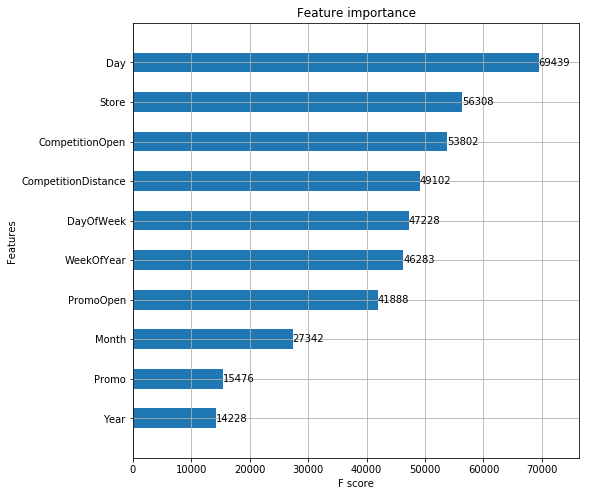

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(gbm, max_num_features= 10, height=0.5, ax=ax)
plt.show()

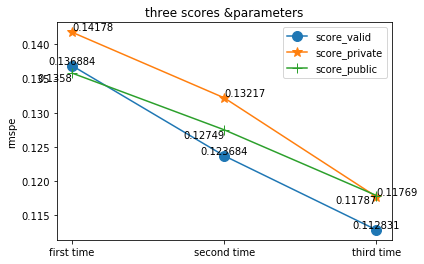

In [81]:
import numpy as np
time = np.arange(1,4)
group_label = ['first time','second time','third time']
score_valid = [0.136884,0.123684,0.112831]
score_private = [0.14178,0.13217,0.11769]
score_public = [0.13580,0.12749,0.11787]
plt.plot(time,score_valid,marker='o',label ='score_valid',markersize =10 )
plt.plot(time,score_private,marker = "*",label = 'score_private',markersize =10)
plt.plot(time,score_public,marker ='+',label = 'score_public',markersize =10)

for a, b in zip(time, score_valid):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)
for a, b in zip(time, score_private):
    plt.text(a, b, b, ha='left', va='bottom', fontsize=10) 
for a, b in zip(time, score_public):
    plt.text(a, b, b, ha='right', va='top', fontsize=10)

plt.legend()

plt.xticks(time,group_label)
plt.ylabel('rmspe')
plt.title("three scores &parameters")
plt.show()